### Libraries and data loading

In [1]:
# import libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import datetime
import itertools
import h5py
import matplotlib.dates as mdates

%matplotlib inline

2025-05-05 20:08:53.828644: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-05 20:08:53.982590: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-05 20:08:54.022018: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-05 20:08:54.818976: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [2]:
# check tensorflow version
print("tensorflow version:", tf.__version__)
# check available gpu
gpus =  tf.config.list_physical_devices('GPU')
print("available gpus:", gpus)
# limit the gpu usage, prevent it from allocating all gpu memory for a simple model
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
# check number of cpus available
print("available cpus:", os.cpu_count())

tensorflow version: 2.10.0
available gpus: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
available cpus: 192


In [3]:
import tensorflow as tf
sys_details = tf.sysconfig.get_build_info()
sys_details["cuda_version"]

'11.2'

In [4]:
# define the data location and load data

data_folder = os.path.join("data")
data_path = os.path.join(data_folder, "2017_2019_images_pv_processed.hdf5")

# !change model name for different models!
model_name = 'SUNSET_nowcast_CNN_Attention_2017_2019_data'
output_folder = os.path.join("model_output", model_name)
if os.path.isdir(output_folder)==False:
    os.makedirs(output_folder)

print("data_folder:", data_folder)
print("data_path:", data_path)
print("output_folder:", output_folder)

data_folder: data
data_path: data/2017_2019_images_pv_processed.hdf5
output_folder: model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data


In [5]:
# generate handler for the hdf5 data
forecast_dataset = h5py.File(data_path, 'r')

# show structure of the hdf5 data
def get_all(name):
    if name!=None:
        print(forecast_dataset[name])
    
forecast_dataset.visit(get_all)

<HDF5 group "/test" (2 members)>
<HDF5 dataset "images_log": shape (14003, 64, 64, 3), type "|u1">
<HDF5 dataset "pv_log": shape (14003,), type "<f8">
<HDF5 group "/trainval" (2 members)>
<HDF5 dataset "images_log": shape (349372, 64, 64, 3), type "|u1">
<HDF5 dataset "pv_log": shape (349372,), type "<f8">


In [6]:
print('-'*50)

# get the input dimension for constructing the model
img_side_len = forecast_dataset['trainval']['images_log'].shape[1]
num_log_term = forecast_dataset['trainval']['images_log'].shape[1]
num_color_channel = forecast_dataset['trainval']['images_log'].shape[3]
image_input_dim = [img_side_len,img_side_len,num_color_channel]

print("image side length:", img_side_len)
print("number of log terms:", num_log_term)
print("number of color channels:", num_color_channel)
print("input image dimension:", image_input_dim)

# load time stamps into the memory
times_trainval = np.load(os.path.join(data_folder,"times_trainval.npy"),allow_pickle=True)
print("times_trainval.shape:", times_trainval.shape)

# Set random seed for reproducibility
np.random.seed(42)

# Select sample ratio to keep (e.g. keep 20%)
sample_ratio = 0.2

# Get original number of samples
num_samples = len(times_trainval)

# Randomly select indices to keep
selected_indices = np.random.choice(num_samples, size=int(num_samples * sample_ratio), replace=False)
selected_indices = np.sort(selected_indices)

# Save selected indices for future use
selected_indices_path = os.path.join(data_folder, "selected_indices.npy")
np.save(selected_indices_path, selected_indices)
print(f"Randomly selected {len(selected_indices)} samples ({sample_ratio*100:.1f}% of total)")
print(f"Selected indices saved to: {selected_indices_path}")

# read through the dataset once in order to cache it but not store it into the memory
## read the data by batch

print('-'*50)
print('data reading start...')

# Use selected indices instead of all data
batch_size = len(selected_indices)//5  # Adjust batch size based on reduced data volume

for i in range(int(len(selected_indices) / batch_size) + 1):  # Use len(selected_indices) instead of num_samples
    start_time = time.time()
    start_idx = (i * batch_size) % len(selected_indices)  # Use len(selected_indices)
    idxs = selected_indices[start_idx:start_idx + batch_size]  # Use selected_indices instead of indices
    
    _ = forecast_dataset['trainval']['images_log'][idxs]
    _ = forecast_dataset['trainval']['pv_log'][idxs]
    
    end_time = time.time()
    print("batch {0} samples: {1} to {2}, {3:.2f}% finished, processing time {4:.2f}s"
          .format(i+1, idxs[0], idxs[-1], (idxs[-1]/num_samples)*100, (end_time-start_time)))

# Temporarily close the dataset, will use "with" statement to open it when we use it
forecast_dataset.close()

--------------------------------------------------
image side length: 64
number of log terms: 64
number of color channels: 3
input image dimension: [64, 64, 3]
times_trainval.shape: (349372,)
Randomly selected 69874 samples (20.0% of total)
Selected indices saved to: data/selected_indices.npy
--------------------------------------------------
data reading start...
batch 1 samples: 0 to 70191, 20.09% finished, processing time 12.77s
batch 2 samples: 70192 to 140256, 40.15% finished, processing time 9.70s
batch 3 samples: 140257 to 209609, 60.00% finished, processing time 9.27s
batch 4 samples: 209618 to 279314, 79.95% finished, processing time 9.75s
batch 5 samples: 279321 to 349345, 99.99% finished, processing time 9.64s
batch 6 samples: 349349 to 349371, 100.00% finished, processing time 0.00s


### Input data pipeline helper functions

In [7]:
def day_block_shuffle(times_trainval, selected_indices=None):
    """
    Modified day-block shuffling function that optionally handles reduced data
    
    Parameters:
        times_trainval: Complete timestamp array
        selected_indices: Optional, indices of reduced data. If None, process all data
    
    Returns:
        Shuffled index array
    """
    # If selected_indices is provided, only process the selected timestamps
    if selected_indices is not None:
        times_trainval = times_trainval[selected_indices]
    
    # Keep only the date part of each timestamp
    dates_trainval = np.zeros_like(times_trainval, dtype=datetime.date)
    for i in range(len(times_trainval)):
        dates_trainval[i] = times_trainval[i].date()

    # Group indices into daily blocks, each containing indices from the same day
    unique_dates = np.unique(dates_trainval)
    blocks = []
    for i in range(len(unique_dates)):
        blocks.append(np.where(dates_trainval == unique_dates[i])[0])

    # Shuffle block order and reconnect
    np.random.seed(1)  # Fixed random seed for reproducibility
    np.random.shuffle(blocks)
    shuffled_indices = np.asarray(list(itertools.chain.from_iterable(blocks)))
    
    # If processing reduced data, need to map back to original indices
    if selected_indices is not None:
        shuffled_indices = selected_indices[shuffled_indices]
    
    return shuffled_indices

In [8]:
def cv_split(split_data, fold_index, num_fold, original_indices=None):
    '''
    Improved cross-validation split function that handles either original or reduced indices
    
    Args:
        split_data: Index array after day_block_shuffle shuffling
        fold_index: Current selected validation fold (0 to num_fold-1)
        num_fold: Total number of cross-validation folds
        original_indices: Optional, indices of the original complete dataset. If provided, split_data should be relative to these indices
        
    Returns:
        data_train: Training set indices (relative to original dataset)
        data_val: Validation set indices (relative to original dataset)
    '''
    # If original_indices is provided, ensure split_data is its subset
    if original_indices is not None:
        if not np.all(np.isin(split_data, original_indices)):
            raise ValueError("split_data must be contained within original_indices")
    
    num_samples = len(split_data)
    indices = np.arange(num_samples)  # Create temporary indices (0 to len(split_data)-1)

    # Create validation set mask
    val_mask = np.zeros(num_samples, dtype=bool)
    start = int(fold_index / num_fold * num_samples)
    end = int((fold_index + 1) / num_fold * num_samples)
    val_mask[start:end] = True

    # Get temporary indices
    val_indices = indices[val_mask]
    train_indices = indices[~val_mask]

    # Shuffle indices (using fold_index as random seed for reproducibility)
    np.random.seed(fold_index)
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)
    
    # Map back to indices in original split_data
    data_train = split_data[train_indices]
    data_val = split_data[val_indices]

    return data_train, data_val

In [9]:
def data_loader(hdf5_data_path, sample_idx, batch_size=256, is_reduced=False):
    '''
    Improved data loading function supporting both full and reduced datasets
    
    Args:
        hdf5_data_path: Path to HDF5 data file
        sample_idx: Sample index array
        batch_size: Batch size (default 256)
        is_reduced: Whether to use reduced dataset (default False)
        
    Returns:
        tf.data.Dataset object yielding (images_log, pv_log) tuples
    '''
    
    def mapping_func_py(hdf5_path, indices):
        '''Core mapping function (executes in Python environment)'''
        # Convert Tensor to Python types
        hdf5_path = hdf5_path.numpy().decode('utf-8')
        indices = sorted(indices.numpy())  # HDF5 requires sorted indices
        
        with h5py.File(hdf5_path, 'r') as f:
            # Select different data group based on whether using reduced dataset
            dataset_key = 'trainval_reduced' if is_reduced else 'trainval'
            
            # Read data
            images = f[dataset_key]['images_log'][indices]
            pv_values = f[dataset_key]['pv_log'][indices]
            
            # Normalize images to [0,1]
            images = tf.image.convert_image_dtype(images, tf.float32)
            pv_values = tf.convert_to_tensor(pv_values, dtype=tf.float32)
            
            return images, pv_values
    
    def mapping_func_tf(hdf5_path, indices):
        '''TensorFlow environment wrapper function'''
        # Use tf.py_function to convert Python function to TensorFlow operation
        images, pv = tf.py_function(
            func=mapping_func_py,
            inp=[hdf5_path, indices],
            Tout=(tf.float32, tf.float32)
        )
        # Set Tensor shapes (to avoid unknown shape issues)
        images.set_shape([None, 64, 64, 3])  # Adjust based on actual image size
        pv.set_shape([None])
        return images, pv
    
    # Create index dataset
    idx_ds = tf.data.Dataset.from_tensor_slices(sample_idx)
    
    # Configure dataset pipeline
    idx_ds = (idx_ds
              .shuffle(buffer_size=len(sample_idx), seed=0)
              .batch(batch_size)
              .repeat()
              .prefetch(tf.data.AUTOTUNE))
    
    # Map to actual data
    dataset = idx_ds.map(
        lambda x: mapping_func_tf(hdf5_data_path, x),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    return dataset

### Model architecture

In [10]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dropout, Dense, Reshape, Multiply, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Model characteristics
num_filters = 24
kernel_size = [3, 3]
pool_size = [2, 2]
strides = 2
dense_size = 1024
drop_rate = 0.4

# define training time parameters
num_epochs = 200 #(The maximum epoches set to 200 and there might be early stopping depends on validation loss)
num_fold = 10 # 10-fold cross-validation
batch_size = 256
learning_rate = 3e-06

def se_attention(input_feature, reduction_ratio=8):

    channel = input_feature.shape[-1]
    
    # Squeeze: Global Average Pooling
    squeeze = GlobalAveragePooling2D()(input_feature)
    
    # Excitation: Fully Connected layers
    excitation = Dense(channel // reduction_ratio, activation='relu')(squeeze)
    excitation = Dense(channel, activation='sigmoid')(excitation)
    excitation = Reshape((1, 1, channel))(excitation)
    
    # Scale the input feature map
    return Multiply()([input_feature, excitation])


# Model architecture with SE Attention
def sunset_model():
    ## Input
    x_in = keras.Input(shape=(64, 64, 3))  # Update shape to match input data (RGB)

    ## 1st convolution block with SE Attention
    x = Conv2D(12, kernel_size, padding="same", activation='relu')(x_in)
    x = BatchNormalization()(x)
    x = se_attention(x)  # Replace with SE Attention
    x = MaxPooling2D(pool_size, strides)(x)

    ## 2nd convolution block with SE Attention
    x = Conv2D(24, kernel_size, padding="same", activation='relu')(x)
    x = BatchNormalization()(x)
    x = se_attention(x)  # Replace with SE Attention
    x = MaxPooling2D(pool_size, strides)(x)

    # Flatten the convolution output for connection with Dense layers
    x = Flatten()(x)

    # Fully connected layers
    x = Dense(dense_size, activation='relu')(x)
    x = Dropout(drop_rate)(x)
    x = Dense(dense_size, activation='relu')(x)
    x = Dropout(drop_rate)(x)

    ## Regression to prediction target
    y_out = keras.layers.Dense(units=1)(x)

    # Construct the model
    model = keras.Model(inputs=x_in, outputs=y_out)

    # Compile the model with an optimizer
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

# Example input dimensions (update based on your dataset)
image_input_dim = (64, 64, 24)  # Example: 64x64 images with 24 channels (time-series images)

# Build the model
model = sunset_model()

# Display the model architecture
model.summary()


2025-05-05 20:09:49.798863: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-05 20:09:50.673858: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22153 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090 D, pci bus id: 0000:99:00.0, compute capability: 8.9


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 12)   336         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 12)  48          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 global_average_pooling2d (Glob  (None, 12)          0           ['batch_normalization[0][0]']

### Model training and validation

Using reduced dataset, total samples: 69874

Repetition 1/10 training started...
Epoch 1/50

Epoch 1: val_loss improved from inf to 93.55371, saving model to model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/repetition_1/best_model_rep_1.h5
245/245 - 62s - loss: 14.9296 - val_loss: 93.5537 - lr: 1.0000e-04 - 62s/epoch - 253ms/step
Epoch 2/50

Epoch 2: val_loss improved from 93.55371 to 16.32243, saving model to model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/repetition_1/best_model_rep_1.h5
245/245 - 19s - loss: 5.5790 - val_loss: 16.3224 - lr: 1.0000e-04 - 19s/epoch - 76ms/step
Epoch 3/50

Epoch 3: val_loss improved from 16.32243 to 6.44344, saving model to model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/repetition_1/best_model_rep_1.h5
245/245 - 19s - loss: 4.7072 - val_loss: 6.4434 - lr: 1.0000e-04 - 19s/epoch - 78ms/step
Epoch 4/50

Epoch 4: val_loss improved from 6.44344 to 5.36999, saving model to model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/r

<Figure size 1000x500 with 0 Axes>

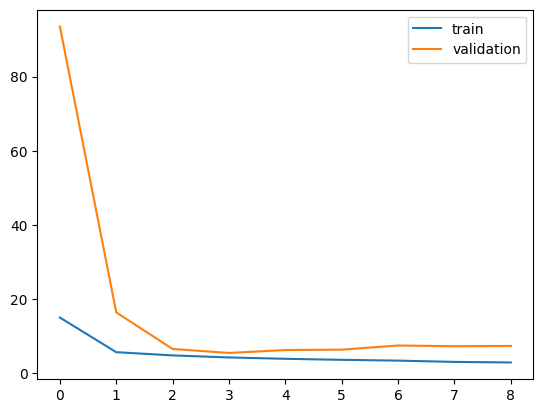


Repetition 2/10 training started...
Epoch 1/50

Epoch 1: val_loss improved from inf to 120.76389, saving model to model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/repetition_2/best_model_rep_2.h5
245/245 - 56s - loss: 15.0952 - val_loss: 120.7639 - lr: 1.0000e-04 - 56s/epoch - 228ms/step
Epoch 2/50

Epoch 2: val_loss improved from 120.76389 to 19.29237, saving model to model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/repetition_2/best_model_rep_2.h5
245/245 - 19s - loss: 5.7460 - val_loss: 19.2924 - lr: 1.0000e-04 - 19s/epoch - 77ms/step
Epoch 3/50

Epoch 3: val_loss improved from 19.29237 to 5.03294, saving model to model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/repetition_2/best_model_rep_2.h5
245/245 - 19s - loss: 4.6661 - val_loss: 5.0329 - lr: 1.0000e-04 - 19s/epoch - 76ms/step
Epoch 4/50

Epoch 4: val_loss improved from 5.03294 to 3.57838, saving model to model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/repetition_2/best_model_rep_2.h5
245/245 -

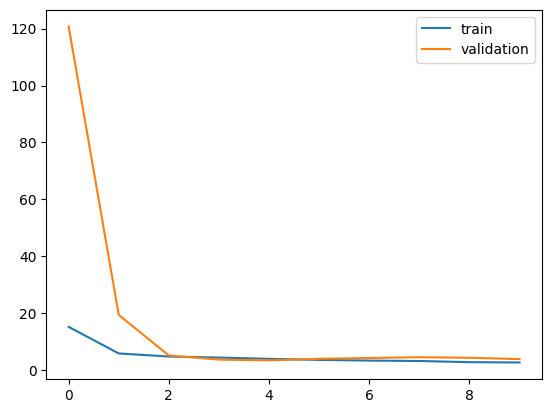


Repetition 3/10 training started...
Epoch 1/50

Epoch 1: val_loss improved from inf to 95.90458, saving model to model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/repetition_3/best_model_rep_3.h5
245/245 - 50s - loss: 14.3312 - val_loss: 95.9046 - lr: 1.0000e-04 - 50s/epoch - 205ms/step
Epoch 2/50

Epoch 2: val_loss improved from 95.90458 to 20.77148, saving model to model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/repetition_3/best_model_rep_3.h5
245/245 - 37s - loss: 5.6437 - val_loss: 20.7715 - lr: 1.0000e-04 - 37s/epoch - 151ms/step
Epoch 3/50

Epoch 3: val_loss improved from 20.77148 to 6.96110, saving model to model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/repetition_3/best_model_rep_3.h5
245/245 - 18s - loss: 4.7005 - val_loss: 6.9611 - lr: 1.0000e-04 - 18s/epoch - 73ms/step
Epoch 4/50

Epoch 4: val_loss improved from 6.96110 to 4.56585, saving model to model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/repetition_3/best_model_rep_3.h5
245/245 - 3

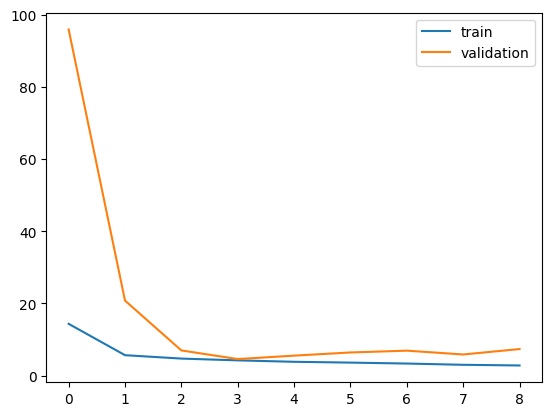


Repetition 4/10 training started...
Epoch 1/50

Epoch 1: val_loss improved from inf to 104.33657, saving model to model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/repetition_4/best_model_rep_4.h5
245/245 - 51s - loss: 14.7565 - val_loss: 104.3366 - lr: 1.0000e-04 - 51s/epoch - 208ms/step
Epoch 2/50

Epoch 2: val_loss improved from 104.33657 to 19.05175, saving model to model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/repetition_4/best_model_rep_4.h5
245/245 - 19s - loss: 5.5036 - val_loss: 19.0518 - lr: 1.0000e-04 - 19s/epoch - 76ms/step
Epoch 3/50

Epoch 3: val_loss improved from 19.05175 to 5.32930, saving model to model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/repetition_4/best_model_rep_4.h5
245/245 - 19s - loss: 4.5748 - val_loss: 5.3293 - lr: 1.0000e-04 - 19s/epoch - 76ms/step
Epoch 4/50

Epoch 4: val_loss did not improve from 5.32930
245/245 - 19s - loss: 4.0012 - val_loss: 5.7648 - lr: 1.0000e-04 - 19s/epoch - 78ms/step
Epoch 5/50

Epoch 5: val_loss i

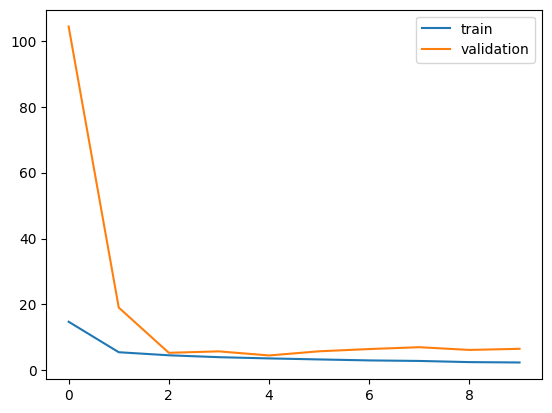


Repetition 5/10 training started...
Epoch 1/50

Epoch 1: val_loss improved from inf to 110.15134, saving model to model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/repetition_5/best_model_rep_5.h5
245/245 - 52s - loss: 14.8137 - val_loss: 110.1513 - lr: 1.0000e-04 - 52s/epoch - 212ms/step
Epoch 2/50

Epoch 2: val_loss improved from 110.15134 to 16.63278, saving model to model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/repetition_5/best_model_rep_5.h5
245/245 - 37s - loss: 5.6074 - val_loss: 16.6328 - lr: 1.0000e-04 - 37s/epoch - 151ms/step
Epoch 3/50

Epoch 3: val_loss improved from 16.63278 to 5.31903, saving model to model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/repetition_5/best_model_rep_5.h5
245/245 - 19s - loss: 4.6876 - val_loss: 5.3190 - lr: 1.0000e-04 - 19s/epoch - 76ms/step
Epoch 4/50

Epoch 4: val_loss improved from 5.31903 to 2.77617, saving model to model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/repetition_5/best_model_rep_5.h5
245/245 

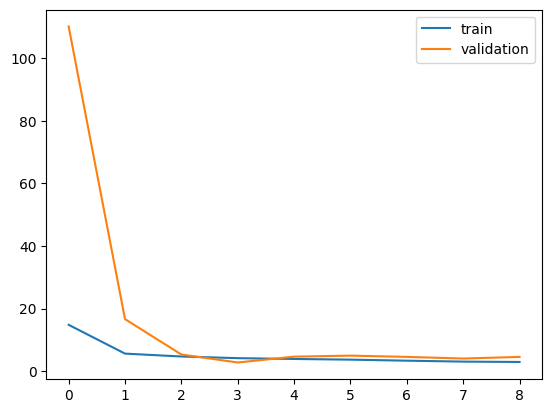


Repetition 6/10 training started...
Epoch 1/50

Epoch 1: val_loss improved from inf to 88.04871, saving model to model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/repetition_6/best_model_rep_6.h5
245/245 - 54s - loss: 14.8002 - val_loss: 88.0487 - lr: 1.0000e-04 - 54s/epoch - 219ms/step
Epoch 2/50

Epoch 2: val_loss improved from 88.04871 to 19.28069, saving model to model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/repetition_6/best_model_rep_6.h5
245/245 - 19s - loss: 5.9916 - val_loss: 19.2807 - lr: 1.0000e-04 - 19s/epoch - 79ms/step
Epoch 3/50

Epoch 3: val_loss improved from 19.28069 to 3.51631, saving model to model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/repetition_6/best_model_rep_6.h5
245/245 - 19s - loss: 4.9557 - val_loss: 3.5163 - lr: 1.0000e-04 - 19s/epoch - 78ms/step
Epoch 4/50

Epoch 4: val_loss improved from 3.51631 to 2.87748, saving model to model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/repetition_6/best_model_rep_6.h5
245/245 - 20

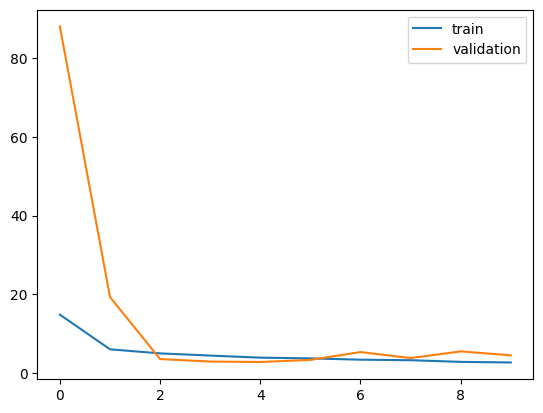


Repetition 7/10 training started...
Epoch 1/50

Epoch 1: val_loss improved from inf to 114.08762, saving model to model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/repetition_7/best_model_rep_7.h5
245/245 - 32s - loss: 15.1749 - val_loss: 114.0876 - lr: 1.0000e-04 - 32s/epoch - 130ms/step
Epoch 2/50

Epoch 2: val_loss improved from 114.08762 to 17.87201, saving model to model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/repetition_7/best_model_rep_7.h5
245/245 - 19s - loss: 5.3635 - val_loss: 17.8720 - lr: 1.0000e-04 - 19s/epoch - 79ms/step
Epoch 3/50

Epoch 3: val_loss improved from 17.87201 to 5.08631, saving model to model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/repetition_7/best_model_rep_7.h5
245/245 - 19s - loss: 4.4278 - val_loss: 5.0863 - lr: 1.0000e-04 - 19s/epoch - 77ms/step
Epoch 4/50

Epoch 4: val_loss improved from 5.08631 to 4.50779, saving model to model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/repetition_7/best_model_rep_7.h5
245/245 -

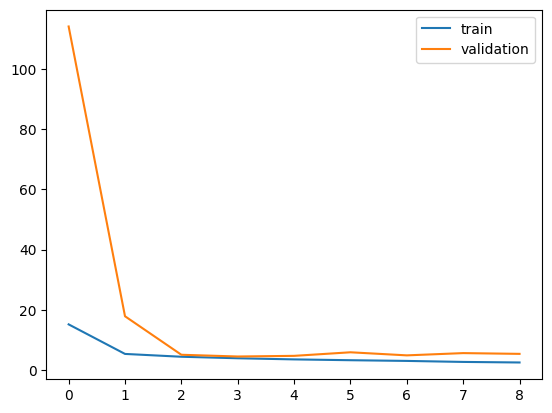


Repetition 8/10 training started...
Epoch 1/50

Epoch 1: val_loss improved from inf to 93.92163, saving model to model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/repetition_8/best_model_rep_8.h5
245/245 - 32s - loss: 15.2602 - val_loss: 93.9216 - lr: 1.0000e-04 - 32s/epoch - 130ms/step
Epoch 2/50

Epoch 2: val_loss improved from 93.92163 to 19.25056, saving model to model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/repetition_8/best_model_rep_8.h5
245/245 - 19s - loss: 5.5483 - val_loss: 19.2506 - lr: 1.0000e-04 - 19s/epoch - 76ms/step
Epoch 3/50

Epoch 3: val_loss improved from 19.25056 to 7.45507, saving model to model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/repetition_8/best_model_rep_8.h5
245/245 - 20s - loss: 4.5507 - val_loss: 7.4551 - lr: 1.0000e-04 - 20s/epoch - 82ms/step
Epoch 4/50

Epoch 4: val_loss improved from 7.45507 to 6.24467, saving model to model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/repetition_8/best_model_rep_8.h5
245/245 - 41

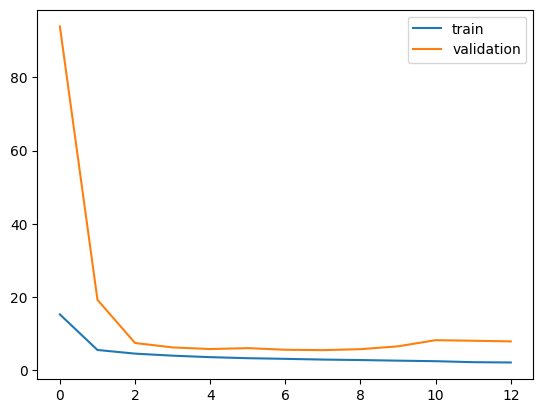


Repetition 9/10 training started...
Epoch 1/50

Epoch 1: val_loss improved from inf to 120.74760, saving model to model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/repetition_9/best_model_rep_9.h5
245/245 - 31s - loss: 15.2551 - val_loss: 120.7476 - lr: 1.0000e-04 - 31s/epoch - 128ms/step
Epoch 2/50

Epoch 2: val_loss improved from 120.74760 to 23.63397, saving model to model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/repetition_9/best_model_rep_9.h5
245/245 - 37s - loss: 5.7355 - val_loss: 23.6340 - lr: 1.0000e-04 - 37s/epoch - 152ms/step
Epoch 3/50

Epoch 3: val_loss improved from 23.63397 to 5.92284, saving model to model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/repetition_9/best_model_rep_9.h5
245/245 - 36s - loss: 4.8016 - val_loss: 5.9228 - lr: 1.0000e-04 - 36s/epoch - 147ms/step
Epoch 4/50

Epoch 4: val_loss improved from 5.92284 to 4.06605, saving model to model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/repetition_9/best_model_rep_9.h5
245/245

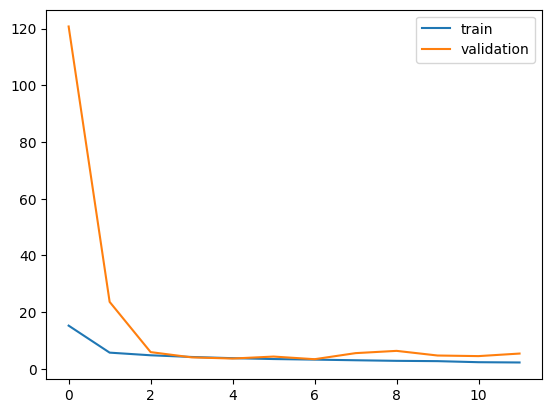


Repetition 10/10 training started...
Epoch 1/50

Epoch 1: val_loss improved from inf to 105.56135, saving model to model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/repetition_10/best_model_rep_10.h5
245/245 - 54s - loss: 16.6396 - val_loss: 105.5613 - lr: 1.0000e-04 - 54s/epoch - 221ms/step
Epoch 2/50

Epoch 2: val_loss improved from 105.56135 to 16.92606, saving model to model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/repetition_10/best_model_rep_10.h5
245/245 - 19s - loss: 6.1155 - val_loss: 16.9261 - lr: 1.0000e-04 - 19s/epoch - 78ms/step
Epoch 3/50

Epoch 3: val_loss improved from 16.92606 to 4.44981, saving model to model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/repetition_10/best_model_rep_10.h5
245/245 - 38s - loss: 4.9676 - val_loss: 4.4498 - lr: 1.0000e-04 - 38s/epoch - 154ms/step
Epoch 4/50

Epoch 4: val_loss improved from 4.44981 to 3.64707, saving model to model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/repetition_10/best_model_rep_10.h5

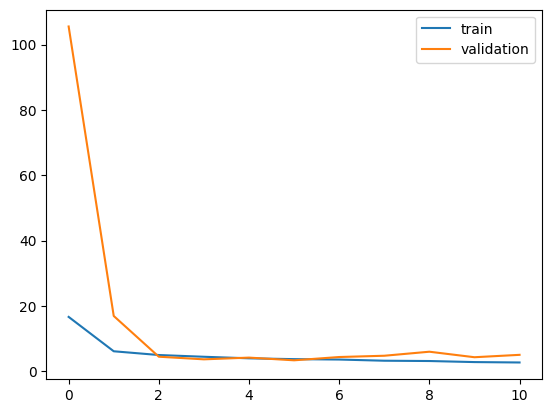

In [14]:
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
import tensorflow as tf

# Configuration
num_fold = 10
num_epochs = 50
batch_size = 256
learning_rate = 1e-4

# Load data
selected_indices = np.load(os.path.join(data_folder, "selected_indices.npy"))
print(f"Using reduced dataset, total samples: {len(selected_indices)}")

indices_dayblock_shuffled = day_block_shuffle(times_trainval, selected_indices=selected_indices)

def data_loader(hdf5_path, sample_idx, batch_size=256):
    def mapping_func_py(hdf5_path, indices):
        hdf5_path = hdf5_path.numpy().decode('utf-8')
        indices = sorted(indices.numpy())
        
        with h5py.File(hdf5_path, 'r') as f:
            images = f['trainval']['images_log'][indices]
            pv = f['trainval']['pv_log'][indices]
            
            images = tf.image.convert_image_dtype(images, tf.float32)
            pv = tf.convert_to_tensor(pv, dtype=tf.float32)
            return images, pv
    
    def mapping_func_tf(hdf5_path, indices):
        images, pv = tf.py_function(
            func=mapping_func_py,
            inp=[hdf5_path, indices],
            Tout=(tf.float32, tf.float32)
        )
        images.set_shape([None, 64, 64, 3])
        pv.set_shape([None])
        return images, pv
    
    idx_ds = tf.data.Dataset.from_tensor_slices(sample_idx)
    idx_ds = idx_ds.shuffle(len(sample_idx)).batch(batch_size).repeat().prefetch(tf.data.AUTOTUNE)
    return idx_ds.map(lambda x: mapping_func_tf(hdf5_path, x), num_parallel_calls=tf.data.AUTOTUNE)

# Initialize containers
train_loss_hist = []
val_loss_hist = []

# Create figure for live plotting
plt.figure(figsize=(10, 5))

for i in range(num_fold):
    keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()
    
    model = sunset_model()
    model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='mse')

    save_directory = os.path.join(output_folder, f'repetition_{i+1}')
    os.makedirs(save_directory, exist_ok=True)

    print(f'\n{"="*50}')
    print(f'Repetition {i+1}/{num_fold} training started...')

    indices_train, indices_val = cv_split(
        indices_dayblock_shuffled, 
        fold_index=i, 
        num_fold=num_fold,
        original_indices=np.arange(len(times_trainval)))
    
    ds_train_batched = data_loader(data_path, indices_train, batch_size)
    ds_val_batched = data_loader(data_path, indices_val, 500)

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
        ModelCheckpoint(
            os.path.join(save_directory, f'best_model_rep_{i+1}.h5'),
            monitor='val_loss', save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
    ]

    try:
        history = model.fit(
            ds_train_batched,
            epochs=num_epochs,
            steps_per_epoch=max(1, len(indices_train)//batch_size),
            validation_data=ds_val_batched,
            validation_steps=max(1, len(indices_val)//500),
            callbacks=callbacks,
            verbose=2
        )
        train_loss_hist.append(history.history['loss'])
        val_loss_hist.append(history.history['val_loss'])
        
        plt.figure()
        plt.plot(train_loss_hist[i], label='train')
        plt.plot(val_loss_hist[i], label='validation')
        plt.legend()
        plt.show()
        
    except Exception as e:
        print(f"Training failed: {str(e)}")
        continue


In [15]:
# summary of training and validation results
best_train_loss_MSE = np.zeros(num_fold)
best_val_loss_MSE = np.zeros(num_fold)

for i in range(num_fold):
    best_val_loss_MSE[i] = np.min(val_loss_hist[i])
    idx = np.argmin(val_loss_hist[i])
    best_train_loss_MSE[i] = train_loss_hist[i][idx]
    print('Model {0}  -- train loss: {1:.2f}, validation loss: {2:.2f} (RMSE)'.format(i+1, np.sqrt(best_train_loss_MSE[i]), np.sqrt(best_val_loss_MSE[i])))
print('The mean train loss (RMSE) for all models is {0:.2f}'.format(np.mean(np.sqrt(best_train_loss_MSE))))
print('The mean validation loss (RMSE) for all models is {0:.2f}'.format(np.mean(np.sqrt(best_val_loss_MSE))))

Model 1  -- train loss: 2.04, validation loss: 2.32 (RMSE)
Model 2  -- train loss: 1.96, validation loss: 1.82 (RMSE)
Model 3  -- train loss: 2.05, validation loss: 2.14 (RMSE)
Model 4  -- train loss: 1.90, validation loss: 2.13 (RMSE)
Model 5  -- train loss: 2.04, validation loss: 1.67 (RMSE)
Model 6  -- train loss: 1.97, validation loss: 1.66 (RMSE)
Model 7  -- train loss: 1.98, validation loss: 2.12 (RMSE)
Model 8  -- train loss: 1.71, validation loss: 2.35 (RMSE)
Model 9  -- train loss: 1.81, validation loss: 1.85 (RMSE)
Model 10  -- train loss: 1.93, validation loss: 1.83 (RMSE)
The mean train loss (RMSE) for all models is 1.94
The mean validation loss (RMSE) for all models is 1.99


In [16]:
# Add the following code at the end of the training script (after the cross-validation loop)

# Save training metrics (RMSE)
train_val_metrics = {
    'mean_train_rmse': np.mean(np.sqrt(best_train_loss_MSE)),
    'mean_val_rmse': np.mean(np.sqrt(best_val_loss_MSE)),
    'all_train_rmse': np.sqrt(best_train_loss_MSE),  # Training RMSE for each fold
    'all_val_rmse': np.sqrt(best_val_loss_MSE)       # Validation RMSE for each fold
}

# Save to model_output root directory (not in repetition_X subdirectories)
np.save(os.path.join(output_folder, 'train_val_metrics.npy'), train_val_metrics)

# Save final model weights (using the best model from last validation)
final_weights_path = os.path.join(output_folder, "final_model_weights.h5")
model.save_weights(final_weights_path)
print(f"\nFinal weights saved to: {final_weights_path}")

# Save model architecture (JSON format, for model reconstruction in GUI)
model_arch_path = os.path.join(output_folder, "model_architecture.json")
with open(model_arch_path, "w") as f:
    f.write(model.to_json())


Final weights saved to: model_output/SUNSET_nowcast_CNN_Attention_2017_2019_data/final_model_weights.h5


### Model testing

In [17]:
# load testing data
times_test = np.load(os.path.join(data_folder,"times_test.npy"),allow_pickle=True)
print("times_test.shape:", times_test.shape)

with h5py.File(data_path,'r') as f:

    # read in the data
    images_log_test = f['test']['images_log'][...]
    pv_log_test = f['test']['pv_log'][...]

# process image data
images_log_test = (images_log_test/255.0).astype('float32')
pv_log_test = pv_log_test.astype('float32')

print("images_log_test.shape:",images_log_test.shape)
print("pv_log_test.shape:",pv_log_test.shape)

times_test.shape: (14003,)
images_log_test.shape: (14003, 64, 64, 3)
pv_log_test.shape: (14003,)


In [18]:
# evaluate model on the test set and generate predictions
loss = np.zeros((num_fold,len(times_test)))
prediction = np.zeros((num_fold,len(times_test)))

for i in range(num_fold):
    # define model path
    print("loading repetition {0} model ...".format(i+1))
    model_path = os.path.join(output_folder,'repetition_'+str(i+1),'best_model_repitition_'+str(i+1)+'.h5')
    # load the trained model
    model = keras.models.load_model(model_path)
    
    # model evaluation
    print("evaluating performance for the model".format(i+1))
    loss[i] = model.evaluate(x=images_log_test, y=pv_log_test, batch_size=200, verbose=1)
    
    # generate prediction
    print("generating predictions for the model".format(i+1))
    prediction[i] = np.squeeze(model.predict(images_log_test, batch_size=200, verbose=1))

# saving predictions from each model
np.save(os.path.join(output_folder,'test_predictions.npy'),prediction)

# using the ensemble mean of the 10 models as the final prediction 
print('-'*50)
print("model ensembling ...")
prediction_ensemble = np.mean(prediction,axis=0)
loss_ensemble = np.sqrt(np.mean((prediction_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} for the ensemble model".format(loss_ensemble))

loading repetition 1 model ...
evaluating performance for the model
71/71 [==============================] - 1s 6ms/step - loss: 7.8778
generating predictions for the model
71/71 [==============================] - 1s 5ms/step
loading repetition 2 model ...
evaluating performance for the model
71/71 [==============================] - 1s 6ms/step - loss: 6.8151
generating predictions for the model
71/71 [==============================] - 1s 5ms/step
loading repetition 3 model ...
evaluating performance for the model
71/71 [==============================] - 1s 6ms/step - loss: 6.7662
generating predictions for the model
71/71 [==============================] - 1s 6ms/step
loading repetition 4 model ...
evaluating performance for the model
71/71 [==============================] - 1s 6ms/step - loss: 6.6654
generating predictions for the model
71/71 [==============================] - 1s 7ms/step
loading repetition 5 model ...
evaluating performance for the model
71/71 [=====================

In [19]:
# formulate sunny and cloudy test days
sunny_dates = [(2017,9,15),(2017,10,6),(2017,10,22),
               (2018,2,16),(2018,6,12),(2018,6,23),
               (2019,1,25),(2019,6,23),(2019,7,14),(2019,10,14)]
cloudy_dates = [(2017,6,24),(2017,9,20),(2017,10,11),
                (2018,1,25),(2018,3,9),(2018,10,4),
                (2019,5,27),(2019,6,28),(2019,8,10),(2019,10,19)]

sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

## generate mask for the sunny days
mask = np.zeros(len(pv_log_test),dtype=bool)
for i in sunny_dates_test:
    mask[np.where(dates_test==i)[0]]=1

## apply the mask to the dataset
times_test_sunny = times_test[mask]
pv_log_test_sunny = pv_log_test[mask]
images_log_test_sunny = images_log_test[mask]
prediction_ensemble_sunny = prediction_ensemble[mask]
print("times_test_sunny.shape:",times_test_sunny.shape)

times_test_cloudy = times_test[~mask]
pv_log_test_cloudy = pv_log_test[~mask]
images_log_test_cloudy = images_log_test[~mask]
prediction_ensemble_cloudy = prediction_ensemble[~mask]
print("times_test_cloudy.shape:",times_test_cloudy.shape)

times_test_sunny.shape: (6986,)
times_test_cloudy.shape: (7017,)


In [20]:
# RMSE for sunny and cloudy days individually
rmse_sunny = np.sqrt(np.mean(np.square((prediction_ensemble_sunny-pv_log_test_sunny))))
rmse_cloudy = np.sqrt(np.mean(np.square((prediction_ensemble_cloudy-pv_log_test_cloudy))))
rmse_overall = np.sqrt((rmse_sunny**2*len(pv_log_test_sunny)+rmse_cloudy**2*len(pv_log_test_cloudy))/(len(pv_log_test)))

print("test set sunny days RMSE: {0:.3f}".format(rmse_sunny))
print("test set cloudy days RMSE: {0:.3f}".format(rmse_cloudy))
print("test set overall RMSE: {0:.3f}".format(rmse_overall))

test set sunny days RMSE: 0.829
test set cloudy days RMSE: 3.429
test set overall RMSE: 2.497


In [21]:
# MAE for sunny and cloudy days individually
mae_sunny = np.mean(np.abs((prediction_ensemble_sunny-pv_log_test_sunny)))
mae_cloudy = np.mean(np.abs((prediction_ensemble_cloudy-pv_log_test_cloudy)))
mae_overall = (mae_cloudy*len(pv_log_test_cloudy) + mae_sunny*len(pv_log_test_sunny))/(len(pv_log_test))

print("test set sunny days MAE: {0:.3f}".format(mae_sunny))
print("test set cloudy days MAE: {0:.3f}".format(mae_cloudy))
print("test set overall MAE: {0:.3f}".format(mae_overall))

test set sunny days MAE: 0.671
test set cloudy days MAE: 2.443
test set overall MAE: 1.559


In [22]:
# R² for sunny and cloudy days individually
r2_sunny = 1 - (np.sum(np.square(prediction_ensemble_sunny - pv_log_test_sunny)) / 
                np.sum(np.square(pv_log_test_sunny - np.mean(pv_log_test_sunny))))
r2_cloudy = 1 - (np.sum(np.square(prediction_ensemble_cloudy - pv_log_test_cloudy)) / 
                 np.sum(np.square(pv_log_test_cloudy - np.mean(pv_log_test_cloudy))))
r2_overall = 1 - (np.sum(np.square(np.concatenate([prediction_ensemble_sunny, prediction_ensemble_cloudy]) - 
                                   np.concatenate([pv_log_test_sunny, pv_log_test_cloudy]))) / 
                  np.sum(np.square(np.concatenate([pv_log_test_sunny, pv_log_test_cloudy]) - 
                                   np.mean(np.concatenate([pv_log_test_sunny, pv_log_test_cloudy])))))

print("test set sunny days R²: {0:.3f}".format(r2_sunny))
print("test set cloudy days R²: {0:.3f}".format(r2_cloudy))
print("test set overall R²: {0:.3f}".format(r2_overall))

test set sunny days R²: 0.987
test set cloudy days R²: 0.792
test set overall R²: 0.893


In [23]:
# EVS for sunny and cloudy days individually
evs_sunny = 1 - (np.var(prediction_ensemble_sunny - pv_log_test_sunny) / 
                 np.var(pv_log_test_sunny))
evs_cloudy = 1 - (np.var(prediction_ensemble_cloudy - pv_log_test_cloudy) / 
                  np.var(pv_log_test_cloudy))
evs_overall = 1 - (np.var(np.concatenate([prediction_ensemble_sunny, prediction_ensemble_cloudy]) - 
                          np.concatenate([pv_log_test_sunny, pv_log_test_cloudy])) / 
                   np.var(np.concatenate([pv_log_test_sunny, pv_log_test_cloudy])))

print("test set sunny days EVS: {0:.3f}".format(evs_sunny))
print("test set cloudy days EVS: {0:.3f}".format(evs_cloudy))
print("test set overall EVS: {0:.3f}".format(evs_overall))

test set sunny days EVS: 0.993
test set cloudy days EVS: 0.806
test set overall EVS: 0.902


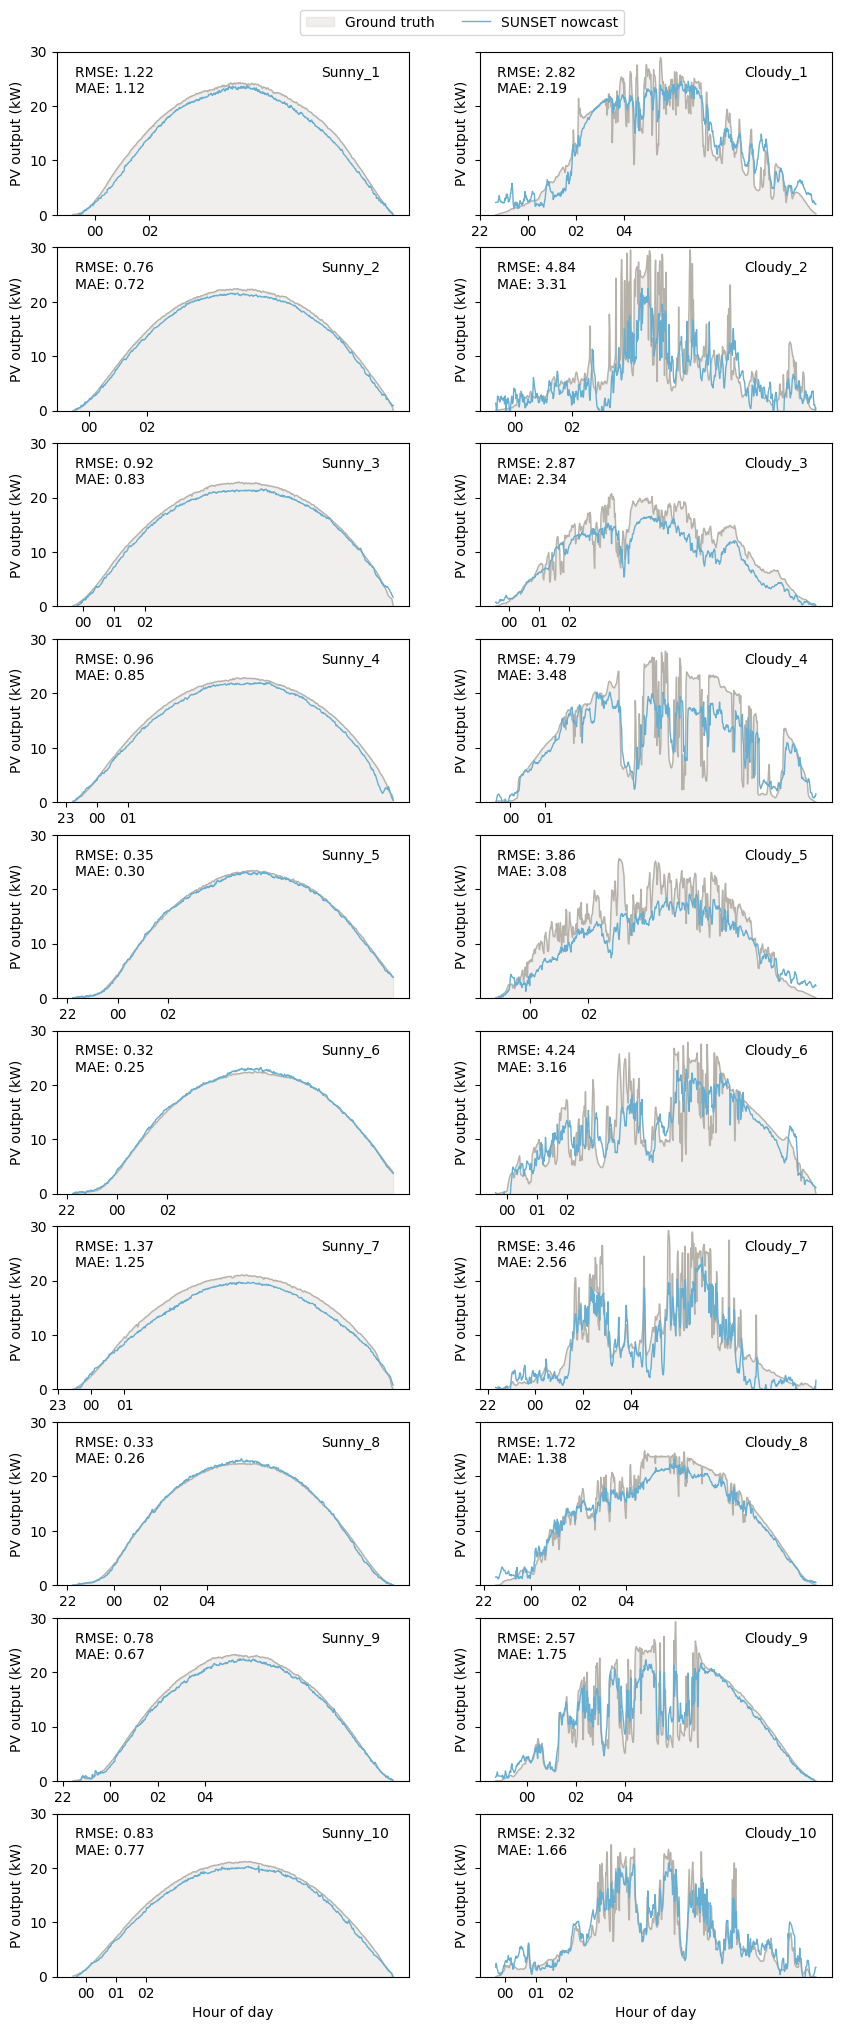

In [24]:
# visualization of nowcast predictions
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(10,2,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

blue = '#67AFD2'
grey =  '#B6B1A9'

for i,date in enumerate(sunny_dates_test):
    ax = axarr[i,0]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]] 
    
    rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-prediction_ensemble[date_mask]))))
    mae = np.mean(np.abs((pv_log_test[date_mask]-prediction_ensemble[date_mask])))
    
    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color=grey)
    ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.plot(hours_xaxis, prediction_ensemble[date_mask],linewidth = 1,label = 'SUNSET nowcast',color=blue,markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.75,0.85,'Sunny_'+str(i+1), transform=ax.transAxes)
    ax.text(0.05,0.75,"RMSE: {0:.2f}\nMAE: {1:.2f}".format(rmse,mae),transform=ax.transAxes)

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i,1]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]] 
    
    rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-prediction_ensemble[date_mask]))))
    mae = np.mean(np.abs((pv_log_test[date_mask]-prediction_ensemble[date_mask])))
    
    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color=grey)
    ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.plot(hours_xaxis, prediction_ensemble[date_mask],linewidth = 1,label = 'SUNSET nowcast',color=blue,markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.75,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)
    ax.text(0.05,0.75,"RMSE: {0:.2f}\nMAE: {1:.2f}".format(rmse,mae),transform=ax.transAxes)

    
axarr[0,0].set_ylim(0, 30)
axarr[0,0].legend(bbox_to_anchor= [1.15,1.3], loc = 'upper center', ncol = 3)
axarr[-1,0].set_xlabel('Hour of day')
axarr[-1,1].set_xlabel('Hour of day')

f.set_size_inches(10,25)    
plt.show()  

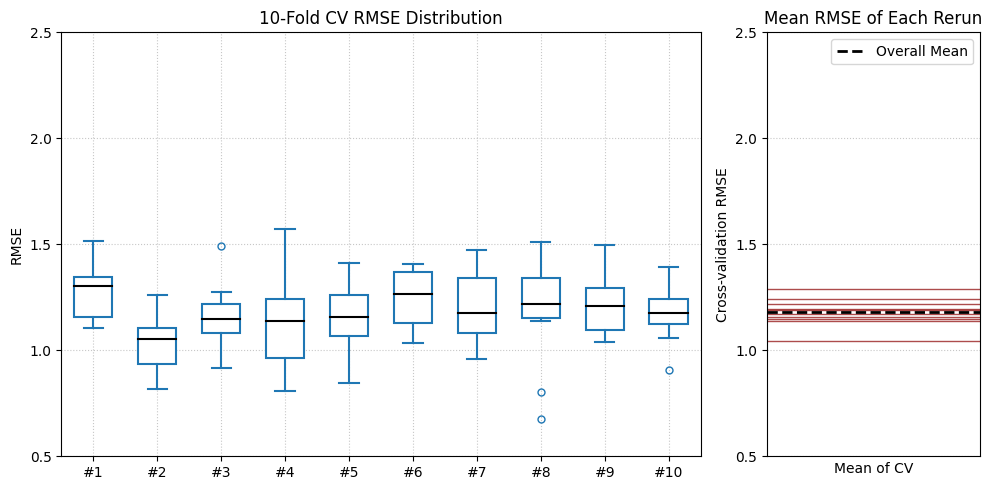

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Generate sample RMSE data
np.random.seed(42)
cv_reruns_rmse = [np.random.normal(1.2, 0.2, 10) for _ in range(10)]

# Calculate statistics
mean_rmse = [np.mean(run) for run in cv_reruns_rmse]  # 10 mean values for 10 reruns
overall_mean = np.mean(mean_rmse)

# Create figure with adjusted subplot widths
plt.figure(figsize=(10, 5))
gs = plt.GridSpec(1, 2, width_ratios=[3, 1])  # Right plot is narrower

# Left plot: Boxplot without mean markers
ax1 = plt.subplot(gs[0])
box = ax1.boxplot(cv_reruns_rmse, 
                 positions=range(1,11),
                 widths=0.6,
                 patch_artist=True,
                 boxprops=dict(facecolor='white', color='#1f77b4', linewidth=1.5),
                 medianprops=dict(color='black', linewidth=1.5),
                 whiskerprops=dict(color='#1f77b4', linewidth=1.5),
                 capprops=dict(color='#1f77b4', linewidth=1.5),
                 flierprops=dict(marker='o', markersize=5, 
                               markerfacecolor='none', markeredgecolor='#1f77b4'))

ax1.set_xticks(range(1,11))
ax1.set_xticklabels([f'#{i}' for i in range(1,11)])
ax1.set_yticks([0.5, 1.0, 1.5, 2.0, 2.5])
ax1.set_ylim(0.5, 2.5)
ax1.set_ylabel('RMSE')
ax1.set_title('10-Fold CV RMSE Distribution')
ax1.grid(True, linestyle=':', alpha=0.7)

# Right plot: Horizontal lines for each rerun's mean RMSE
ax2 = plt.subplot(gs[1])

# Plot each mean RMSE as a horizontal line
for i, mean_val in enumerate(mean_rmse):
    ax2.axhline(y=mean_val, color='#8B0000', linewidth=1, alpha=0.7)

# Add overall mean line
ax2.axhline(y=overall_mean, color='black', linewidth=2, linestyle='--', label='Overall Mean')

ax2.set_xlim(-0.5, 0.5)
ax2.set_ylim(0.5, 2.5)
ax2.set_yticks([0.5, 1.0, 1.5, 2.0, 2.5])
ax2.set_xticks([])
ax2.set_xlabel('Mean of CV')
ax2.set_ylabel('Cross-validation RMSE')
ax2.set_title('Mean RMSE of Each Rerun')
ax2.legend(loc='upper right')
ax2.grid(True, axis='y', linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()

=== Enhanced Heatmap Visualization with Elliptical Mask ===


/tmp/ipykernel_1509/760275301.py:101: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


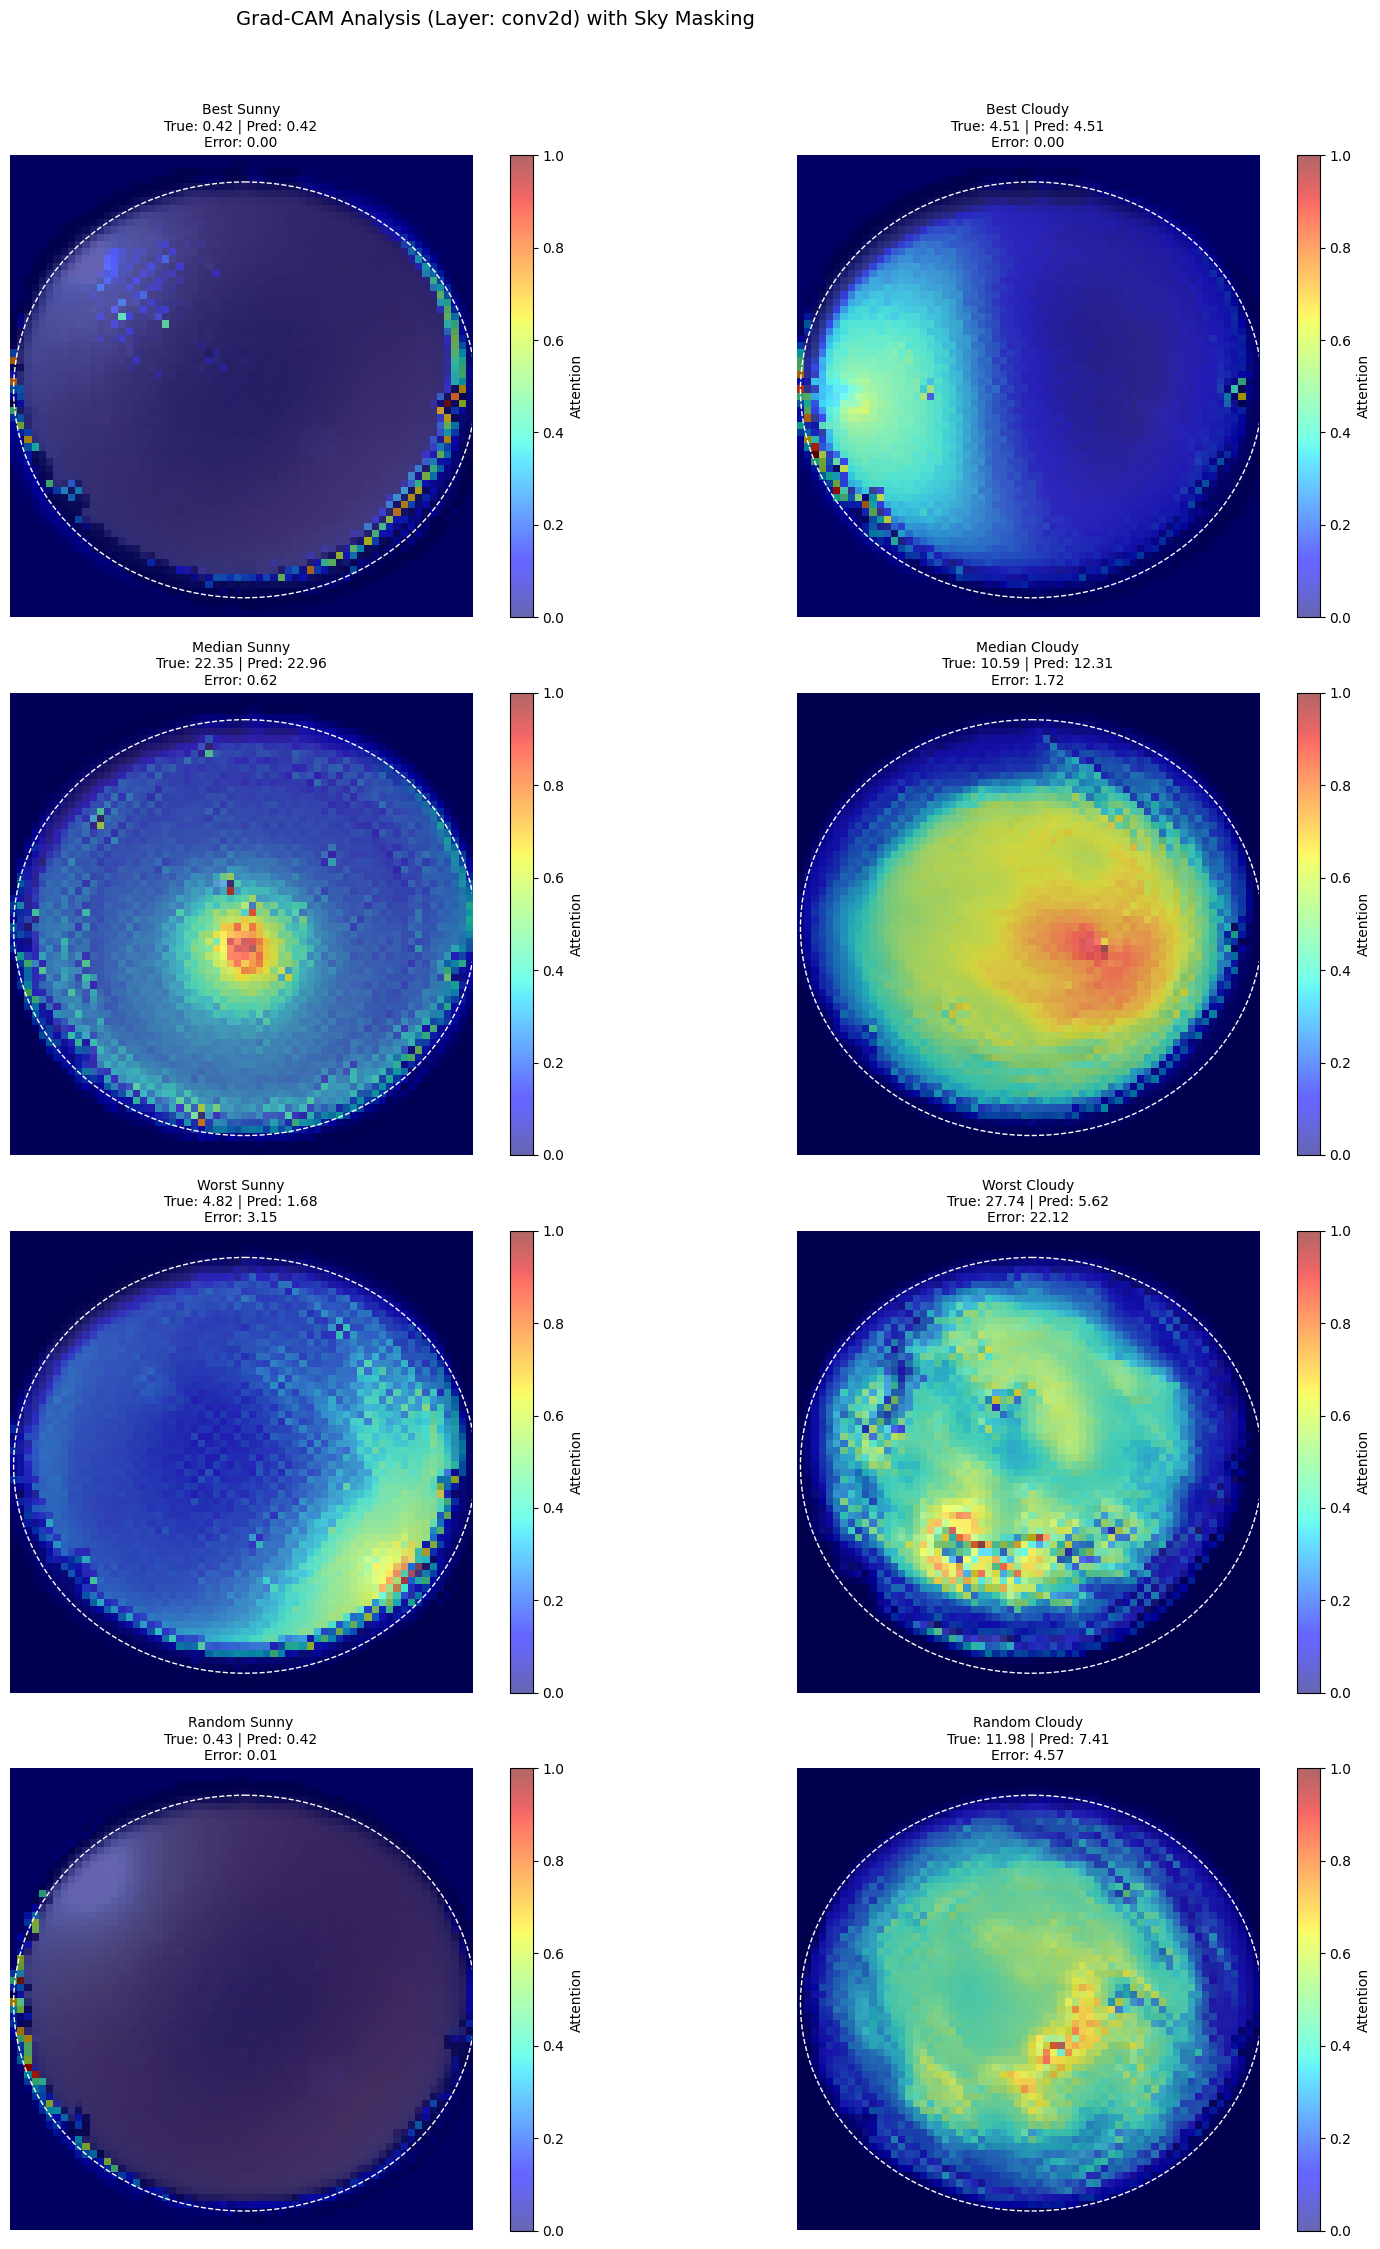

In [33]:
import tensorflow as tf
from tensorflow.keras.models import Model
import matplotlib.cm as cm
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.measure import find_contours

def create_sky_mask(image_size, ellipse_ratio=1.0, random_offset=False, random_deform=0.0):
    """
    Generate precise sky mask with configurable elliptical shape
    Args:
        image_size: (height, width) tuple
        ellipse_ratio: vertical/horizontal axis ratio (1.0=circle)
        random_offset: whether to allow small center offsets (fixed camera)
        random_deform: degree of random ellipse deformation (0-0.2)
    Returns:
        Binary mask with elliptical sky region
    """
    h, w = image_size[:2]
    center = (h//2, w//2)
    base_radius = min(h, w) // 2
    
    # Apply elliptical ratio and random deformation
    radius_x = int(base_radius * (1.0 + random_deform * np.random.uniform(-1,1)))
    radius_y = int(base_radius * ellipse_ratio * (1.0 + random_deform * np.random.uniform(-1,1)))
    
    # Small center offset for fixed camera (max 2% of image size)
    if random_offset:
        max_offset = int(0.02 * min(h,w))
        offset_x = np.random.randint(-max_offset, max_offset+1)
        offset_y = np.random.randint(-max_offset, max_offset+1)
        center = (center[0] + offset_x, center[1] + offset_y)
    
    # Generate precise elliptical mask
    mask = np.zeros((h, w), dtype=np.float32)
    y, x = np.ogrid[:h, :w]
    dist = ((x - center[1])/radius_x)**2 + ((y - center[0])/radius_y)**2
    mask[dist <= 1] = 1
    
    return mask

def apply_mask_with_blur(image, mask, blur_kernel=(5,5)):
    """Apply mask with smooth edges using Gaussian blur"""
    blurred_mask = cv2.GaussianBlur(mask, blur_kernel, 0)
    if len(image.shape) == 3:
        blurred_mask = np.expand_dims(blurred_mask, axis=-1)
    return image * blurred_mask

def safe_gradcam_heatmap(model, img_array, layer_name="conv2d"):
    """Robust Grad-CAM implementation with error handling"""
    try:
        grad_model = tf.keras.models.Model(
            inputs=model.inputs,
            outputs=[model.get_layer(layer_name).output, model.output]
        )
        
        with tf.GradientTape(persistent=True) as tape:
            conv_outputs, predictions = grad_model(img_array)
            loss = tf.reduce_mean(predictions)
            if loss is None:
                raise ValueError("Model returns None loss")
        
        grads = tape.gradient(loss, conv_outputs)
        if grads is None:
            raise ValueError(f"Gradients are None for layer {layer_name}")
        
        weights = tf.reduce_mean(grads, axis=(1, 2), keepdims=True)
        heatmap = tf.reduce_sum(conv_outputs * weights, axis=-1)
        heatmap = tf.maximum(heatmap, 0)
        
        max_val = tf.reduce_max(heatmap)
        if max_val == 0:
            print(f"Warning: All zeros in heatmap for layer {layer_name}")
            return np.zeros_like(heatmap[0])
            
        return (heatmap / max_val)[0].numpy()
    
    except Exception as e:
        print(f"Error in layer {layer_name}: {str(e)}")
        return np.zeros(img_array.shape[1:-1])

def visualize_gradcam_enhanced(model, sunny_images, sunny_true, sunny_pred, 
                             cloudy_images, cloudy_true, cloudy_pred,
                             layer_name="conv2d", apply_mask=False,
                             ellipse_ratio=1.0, show_contour=True):
    """
    Enhanced visualization with elliptical masks and individual color bars
    Args:
        ellipse_ratio: vertical/horizontal axis ratio for sky region
        show_contour: whether to display sky region contour
    """
    # Create subplot layout
    fig, axs = plt.subplots(4, 2, figsize=(18, 22))
    fig.suptitle(f"Grad-CAM Analysis (Layer: {layer_name})" + 
                (" with Sky Masking" if apply_mask else ""), 
                y=1.02, fontsize=14)
    
    # Colormap configuration
    norm = plt.Normalize(vmin=0, vmax=1)
    jet = cm.get_cmap("jet")
    
    # Sample selection
    sunny_samples = [
        ("Best Sunny", np.argmin(np.abs(sunny_pred - sunny_true))),
        ("Median Sunny", np.argsort(np.abs(sunny_pred - sunny_true))[len(sunny_pred)//2]),
        ("Worst Sunny", np.argmax(np.abs(sunny_pred - sunny_true))),
        ("Random Sunny", np.random.choice(len(sunny_pred)))
    ]
    
    cloudy_samples = [
        ("Best Cloudy", np.argmin(np.abs(cloudy_pred - cloudy_true))),
        ("Median Cloudy", np.argsort(np.abs(cloudy_pred - cloudy_true))[len(cloudy_pred)//2]),
        ("Worst Cloudy", np.argmax(np.abs(cloudy_pred - cloudy_true))),
        ("Random Cloudy", np.random.choice(len(cloudy_pred)))
    ]
    
    for row in range(4):
        # Process sunny sample
        desc, idx = sunny_samples[row]
        img = sunny_images[idx].copy()
        
        if apply_mask:
            mask = create_sky_mask(img.shape, ellipse_ratio, random_offset=False)
            img = apply_mask_with_blur(img, mask)
        
        heatmap = safe_gradcam_heatmap(model, np.expand_dims(img, axis=0), layer_name)
        
        axs[row, 0].imshow(img)
        if apply_mask and show_contour:
            h, w = img.shape[:2]
            from matplotlib.patches import Ellipse
            ellipse = Ellipse((w//2, h//2), min(h,w), min(h,w)*ellipse_ratio,
                            fill=False, color='white', linestyle='--', linewidth=1)
            axs[row, 0].add_artist(ellipse)
        
        im1 = axs[row, 0].imshow(heatmap, cmap=jet, alpha=0.6, norm=norm)
        axs[row, 0].set_title(f"{desc}\nTrue: {sunny_true[idx]:.2f} | Pred: {sunny_pred[idx]:.2f}\nError: {abs(sunny_pred[idx]-sunny_true[idx]):.2f}",
                           fontsize=10)
        axs[row, 0].axis('off')
        fig.colorbar(im1, ax=axs[row, 0], fraction=0.046, pad=0.04, label='Attention')
        
        # Process cloudy sample
        desc, idx = cloudy_samples[row]
        img = cloudy_images[idx].copy()
        
        if apply_mask:
            mask = create_sky_mask(img.shape, ellipse_ratio, random_offset=False)
            img = apply_mask_with_blur(img, mask)
        
        heatmap = safe_gradcam_heatmap(model, np.expand_dims(img, axis=0), layer_name)
        
        axs[row, 1].imshow(img)
        if apply_mask and show_contour:
            h, w = img.shape[:2]
            ellipse = Ellipse((w//2, h//2), min(h,w), min(h,w)*ellipse_ratio,
                            fill=False, color='white', linestyle='--', linewidth=1)
            axs[row, 1].add_artist(ellipse)
        
        im2 = axs[row, 1].imshow(heatmap, cmap=jet, alpha=0.6, norm=norm)
        axs[row, 1].set_title(f"{desc}\nTrue: {cloudy_true[idx]:.2f} | Pred: {cloudy_pred[idx]:.2f}\nError: {abs(cloudy_pred[idx]-cloudy_true[idx]):.2f}",
                            fontsize=10)
        axs[row, 1].axis('off')
        fig.colorbar(im2, ax=axs[row, 1], fraction=0.046, pad=0.04, label='Attention')
    
    plt.tight_layout()
    plt.show()

# Example usage with elliptical mask (vertical ratio 0.9)
print("=== Enhanced Heatmap Visualization with Elliptical Mask ===")
visualize_gradcam_enhanced(
    model=model,
    sunny_images=images_log_test_sunny,
    sunny_true=pv_log_test_sunny,
    sunny_pred=prediction_ensemble_sunny,
    cloudy_images=images_log_test_cloudy,
    cloudy_true=pv_log_test_cloudy,
    cloudy_pred=prediction_ensemble_cloudy,
    layer_name="conv2d",
    apply_mask=True,
    ellipse_ratio=0.9  # Vertical compression ratio
)

Generating heatmaps...
Progress: Cloudy 30/30
Done!


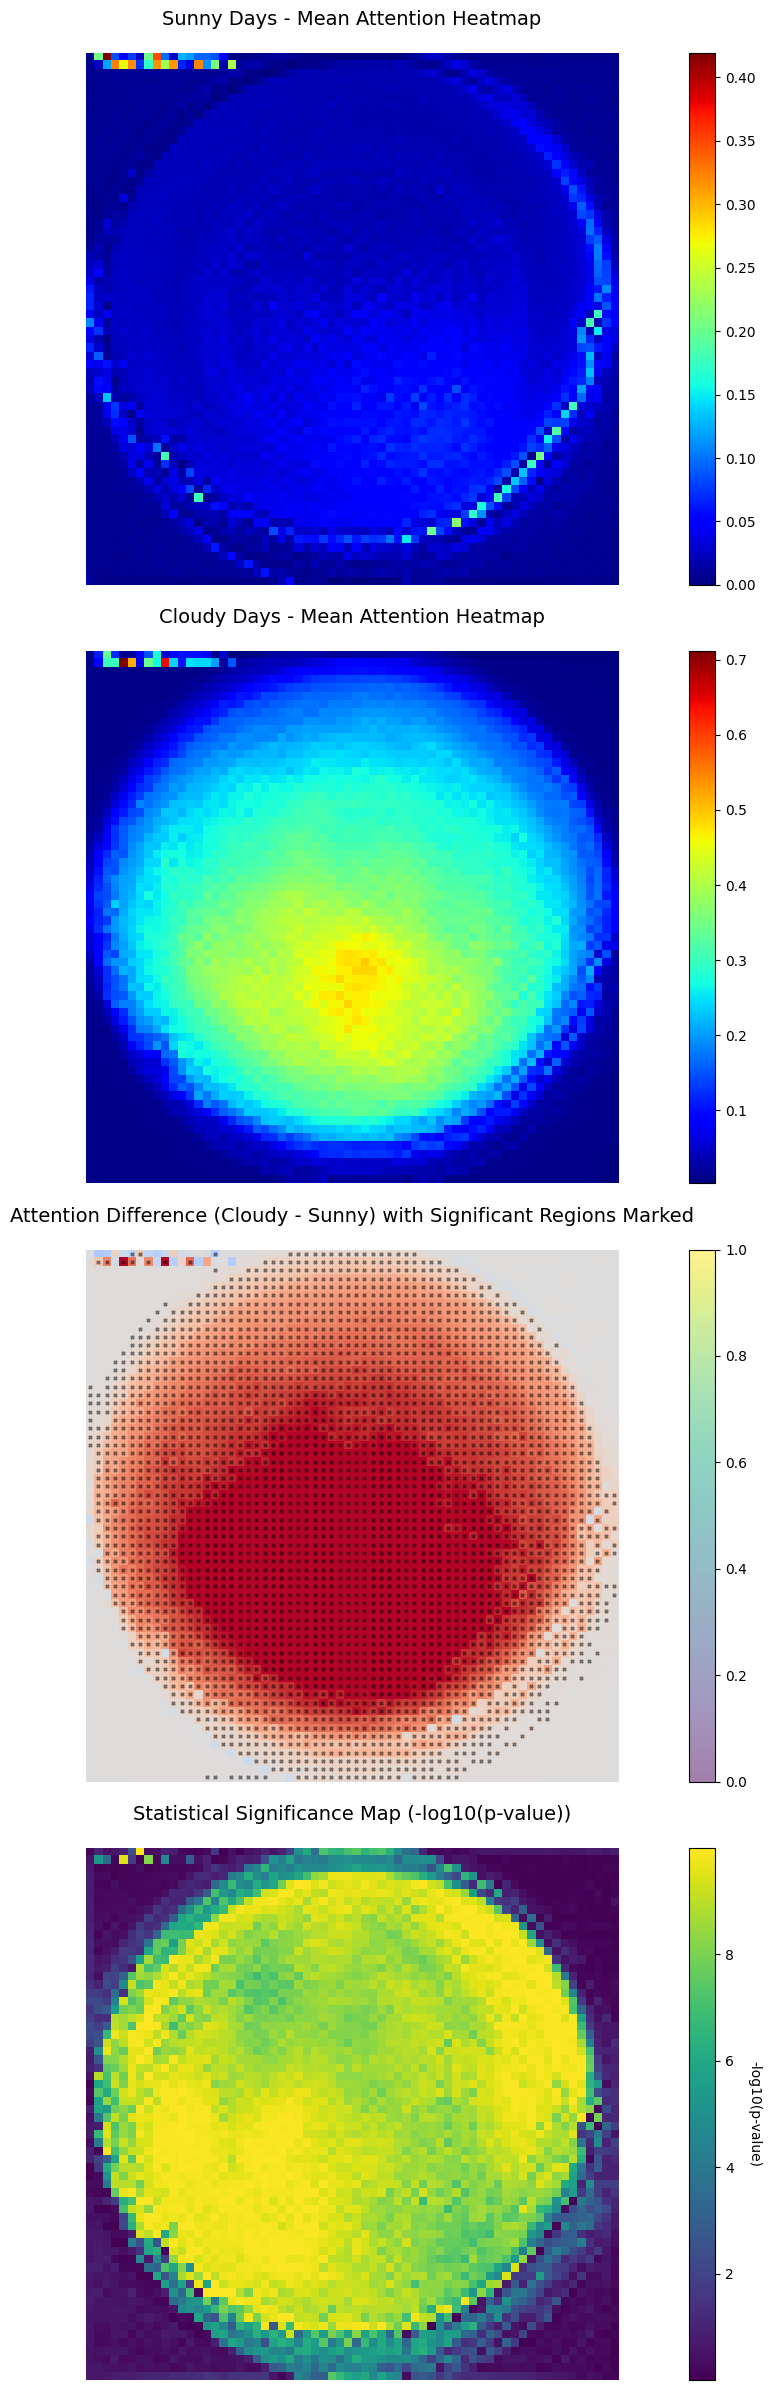

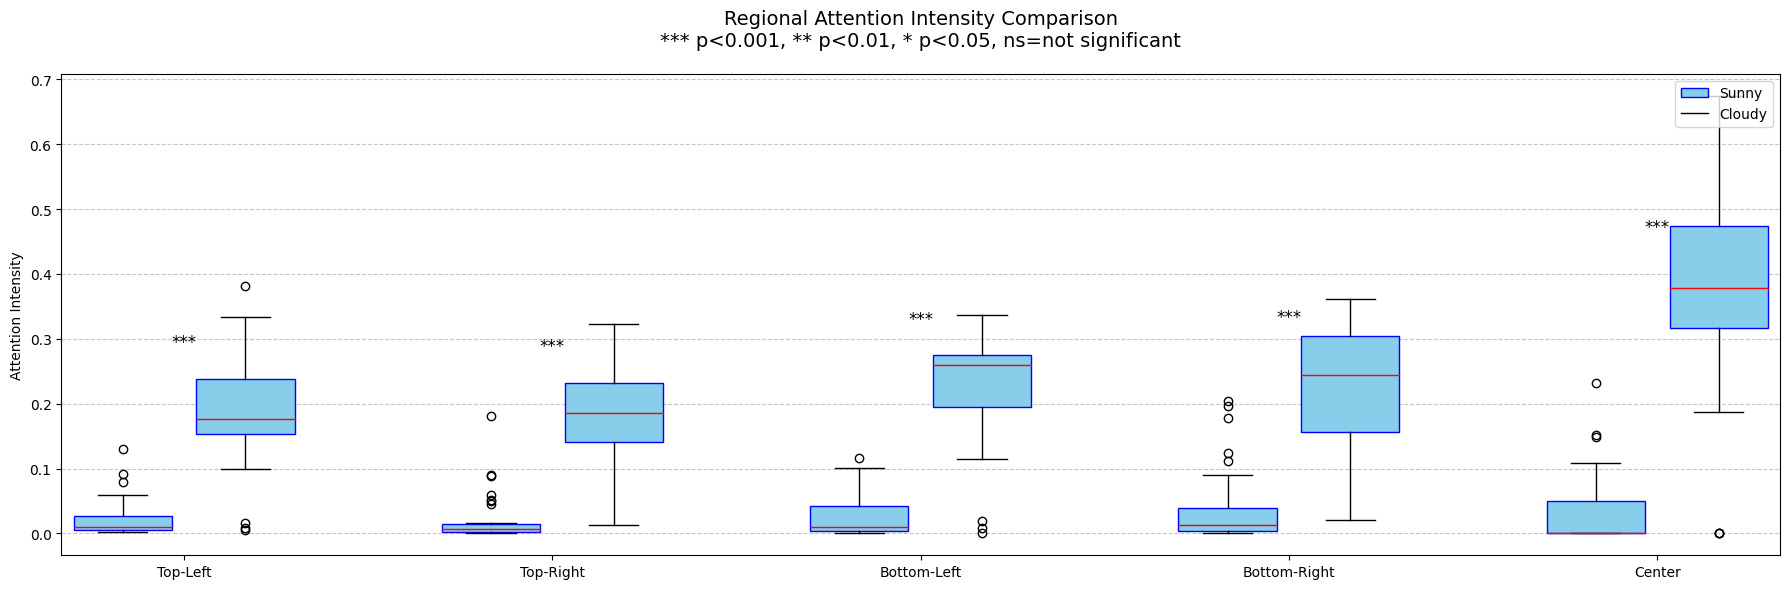

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind  # Add this import
from matplotlib import cm
import tensorflow as tf

def compare_attention_patterns(n_samples=20, layer_name="conv2d"):
    """
    Enhanced attention pattern comparison analysis
    Parameters:
        n_samples: Number of samples to analyze for each weather condition
        layer_name: Name of the model layer to analyze
    """
    # 1. Data preparation
    sunny_heatmaps = []
    cloudy_heatmaps = []
    
    # Random sample selection (avoid sequential bias)
    sunny_indices = np.random.choice(len(images_log_test_sunny), n_samples, replace=False)
    cloudy_indices = np.random.choice(len(images_log_test_cloudy), n_samples, replace=False)
    
    # 2. Generate heatmaps (with progress display)
    print("Generating heatmaps...")
    for i, idx in enumerate(sunny_indices):
        heatmap = safe_gradcam_heatmap(model, np.expand_dims(images_log_test_sunny[idx], 0), layer_name)
        sunny_heatmaps.append(heatmap)
        print(f"Progress: Sunny {i+1}/{n_samples}", end='\r')
    
    for i, idx in enumerate(cloudy_indices):
        heatmap = safe_gradcam_heatmap(model, np.expand_dims(images_log_test_cloudy[idx], 0), layer_name)
        cloudy_heatmaps.append(heatmap)
        print(f"Progress: Cloudy {i+1}/{n_samples}", end='\r')
    print("\nDone!")
    
    # Convert to numpy arrays
    sunny_heatmaps = np.array(sunny_heatmaps)
    cloudy_heatmaps = np.array(cloudy_heatmaps)
    
    # 3. Significance testing (t-test)
    def spatial_ttest(heatmap1, heatmap2):
        """Pixel-wise t-test"""
        h, w = heatmap1.shape[1], heatmap1.shape[2]
        p_values = np.zeros((h, w))
        for i in range(h):
            for j in range(w):
                _, p_values[i,j] = ttest_ind(heatmap1[:,i,j], heatmap2[:,i,j], equal_var=False)
        return p_values
    
    p_values = spatial_ttest(sunny_heatmaps, cloudy_heatmaps)
    sig_mask = p_values < 0.05  # Significance mask

    # 4. Calculate statistical results
    sunny_mean = np.mean(sunny_heatmaps, axis=0)
    cloudy_mean = np.mean(cloudy_heatmaps, axis=0)
    diff = cloudy_mean - sunny_mean
    
    regions = {
        'Top-Left': (0, 0, 32, 32),
        'Top-Right': (0, 32, 32, 64),
        'Bottom-Left': (32, 0, 64, 32),
        'Bottom-Right': (32, 32, 64, 64),
        'Center': (16, 16, 48, 48)
    }
    
    region_stats = {}
    for name, (y1, x1, y2, x2) in regions.items():
        sunny_vals = sunny_heatmaps[:, y1:y2, x1:x2].mean(axis=(1,2))
        cloudy_vals = cloudy_heatmaps[:, y1:y2, x1:x2].mean(axis=(1,2))
        _, p_val = ttest_ind(sunny_vals, cloudy_vals)
        region_stats[name] = {
            'sunny_mean': np.mean(sunny_vals),
            'cloudy_mean': np.mean(cloudy_vals),
            'p_value': p_val
        }
    
    stats = {
        'global_diff': np.mean(diff),
        'max_diff': np.max(np.abs(diff)),
        'significant_pixels': np.sum(sig_mask),
        'region_stats': region_stats,
        'p_values': p_values
    }

    # 5. Visualization section
    plt.figure(figsize=(18, 24))
    
    # Row 1: Sunny mean heatmap
    plt.subplot(4, 1, 1)
    plt.imshow(sunny_mean, cmap='jet')
    plt.title("Sunny Days - Mean Attention Heatmap", fontsize=14, pad=20)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis('off')
    
    # Row 2: Cloudy mean heatmap
    plt.subplot(4, 1, 2)
    plt.imshow(cloudy_mean, cmap='jet')
    plt.title("Cloudy Days - Mean Attention Heatmap", fontsize=14, pad=20)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis('off')
    
    # Row 3: Difference map (with significance markers)
    plt.subplot(4, 1, 3)
    plt.imshow(diff, cmap='coolwarm', vmin=-0.3, vmax=0.3)
    y, x = np.where(p_values < 0.05)
    plt.scatter(x, y, color='black', s=5, alpha=0.5, marker='x')
    plt.title("Attention Difference (Cloudy - Sunny) with Significant Regions Marked", 
             fontsize=14, pad=20)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis('off')
    
    # Row 4: Significance heatmap
    plt.subplot(4, 1, 4)
    significance = -np.log10(p_values + 1e-10)
    plt.imshow(significance, cmap='viridis')
    plt.title("Statistical Significance Map (-log10(p-value))", fontsize=14, pad=20)
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    cbar.set_label('-log10(p-value)', rotation=270, labelpad=20)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Regional analysis displayed separately
    plt.figure(figsize=(18, 6))
    for i, (name, _) in enumerate(regions.items()):
        stats = region_stats[name]
        plt.boxplot([sunny_heatmaps[:, regions[name][0]:regions[name][2], regions[name][1]:regions[name][3]].mean(axis=(1,2)),
                    cloudy_heatmaps[:, regions[name][0]:regions[name][2], regions[name][1]:regions[name][3]].mean(axis=(1,2))], 
                   positions=[i*3, i*3+1], 
                   widths=0.8,
                   patch_artist=True,
                   boxprops=dict(facecolor='skyblue', color='blue'),
                   medianprops=dict(color='red'))
        
        # Add significance asterisks
        if stats['p_value'] < 0.001:
            sig_symbol = '***'
        elif stats['p_value'] < 0.01:
            sig_symbol = '**'
        elif stats['p_value'] < 0.05:
            sig_symbol = '*'
        else:
            sig_symbol = 'ns'
            
        plt.text(i*3+0.5, max(stats['sunny_mean'], stats['cloudy_mean']) + 0.1, 
                sig_symbol, ha='center', fontsize=12)
    
    plt.xticks([i*3+0.5 for i in range(len(regions))], regions.keys())
    plt.title("Regional Attention Intensity Comparison\n*** p<0.001, ** p<0.01, * p<0.05, ns=not significant", 
             fontsize=14, pad=20)
    plt.ylabel("Attention Intensity")
    plt.legend(['Sunny', 'Cloudy'], loc='upper right')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    return stats

# Usage example
attention_stats = compare_attention_patterns(
    n_samples=30,
    layer_name="conv2d"
)